<a href="https://colab.research.google.com/github/RaoSharjeelKhan/Machine-Learning/blob/main/Bone%20Fracture%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STEP (1/6)

First, we import the dataset from Google Drive to our notebook





In [ ]:
#I moved the Dataset to Google Drive For Easy Access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unziping the Dataset File

In [ ]:
from zipfile import ZipFile
DT="/content/drive/MyDrive/Project Dataset/BoneFractureDataset.zip"
with ZipFile(DT, 'r') as zip:
  zip.extractall()

Let's examine the contents inside the folder

In [ ]:
!ls "/content/archive (6)"

train  val


#STEP (2/6)

Import the libraries that we may need for our project

In [ ]:
!pip install keras_tuner # TO optimize our model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from keras_tuner import RandomSearch #To search Hyperparameters
import keras_tuner as kt

#STEP (3/6)

Loading the dataset and preparing it for training the model



In [ ]:
train_dir='/content/archive (6)/train'

test_dir='/content/archive (6)/val'

BATCH_SIZE=32

IMG_DIM=224

In [ ]:
train_df=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',    
    
    batch_size=BATCH_SIZE,
    image_size=(IMG_DIM, IMG_DIM),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset="training",
)
val_df=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',    
    
    batch_size=BATCH_SIZE,
    image_size=(IMG_DIM, IMG_DIM),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset="validation",
)
test_df=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    
    batch_size=BATCH_SIZE,
    image_size=(IMG_DIM, IMG_DIM),
    shuffle=True,
)

Found 8863 files belonging to 2 classes.
Using 7977 files for training.
Found 8863 files belonging to 2 classes.
Using 886 files for validation.
Found 600 files belonging to 2 classes.


#STEP (4/6)

Let's view the images in the folder

In [ ]:
class_names = train_df.class_names
print(class_names)

['fractured', 'not fractured']


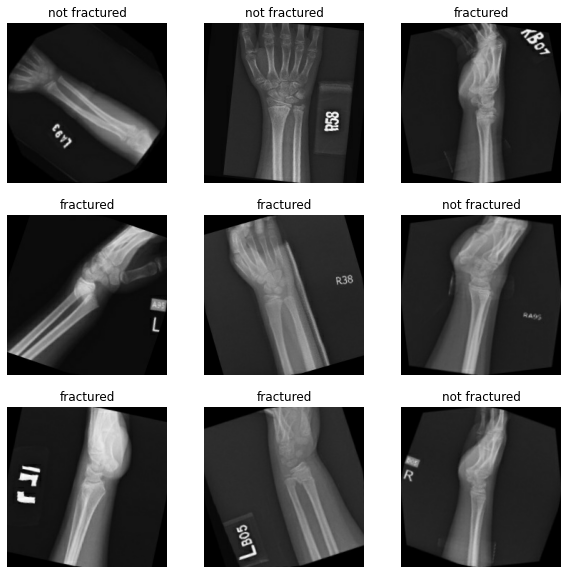

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Image augmentation has already been applied to the dataset, reducing the risk of overfitting.


In [ ]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#STEP (5/6)

Let's train the model using three different methods:

1. A simple CNN model
2. Optimizing the model through hyperparameter tuning
3. Utilizing a pre-trained model from TensorFlow Hub.

### A Simple CNN model

In [ ]:
num_classes = 1

model = tf.keras.Sequential([
  
  tf.keras.layers.Rescaling(1./255), #Rescaling the images
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
]) 
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history=model.fit(
  train_df,
  validation_data=val_df,
  epochs=10
)

Epoch 1/10
250/250 [==============================] - 14s 54ms/step - loss: 0.4935 - accuracy: 0.7529 - val_loss: 0.2045 - val_accuracy: 0.9233
Epoch 2/10
250/250 [==============================] - 12s 45ms/step - loss: 0.1302 - accuracy: 0.9540 - val_loss: 0.0865 - val_accuracy: 0.9650
Epoch 3/10
250/250 [==============================] - 12s 48ms/step - loss: 0.0323 - accuracy: 0.9895 - val_loss: 0.0480 - val_accuracy: 0.9853
Epoch 4/10
250/250 [==============================] - 12s 46ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 0.0445 - val_accuracy: 0.9876
Epoch 5/10
250/250 [==============================] - 12s 47ms/step - loss: 0.0208 - accuracy: 0.9932 - val_loss: 0.0526 - val_accuracy: 0.9819
Epoch 6/10
250/250 [==============================] - 14s 54ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0293 - val_accuracy: 0.9910
Epoch 7/10
250/250 [==============================] - 12s 45ms/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.0623 - val_accuracy:

Model is not overfiting the data as we predicted. Now let see can we make our model to perform much better Using Hyperparameter Tuning.

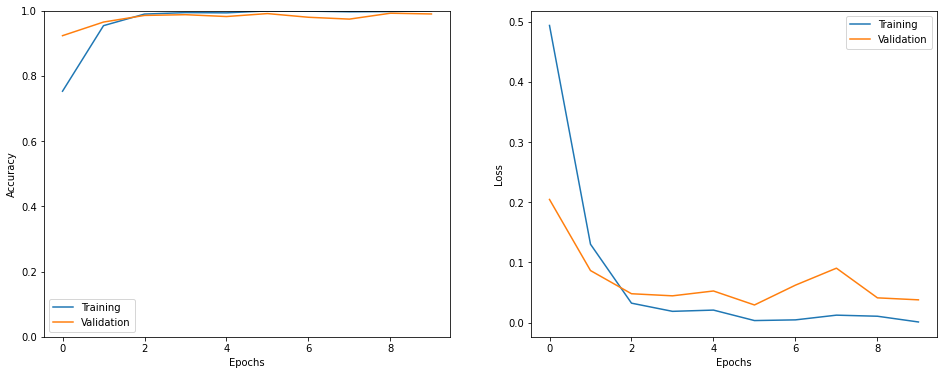

In [ ]:
show_history(history)

### Optimizing the model through hyperparameter tuning

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential([
        
        tf.keras.layers.Rescaling(1./255),

        tf.keras.layers.Conv2D(
            hp.Int('conv_1_filter', min_value=8, max_value=64, step=8), 
            hp.Choice('conv_1_kernel', values=[3,5]), 
            activation='relu'),

        tf.keras.layers.MaxPooling2D(),


        tf.keras.layers.Conv2D(
            hp.Int('conv_2_filter', min_value=16, max_value=128, step=16), 
            hp.Choice('conv_2_kernel', values=[3,5]), 
            activation='relu'),

        tf.keras.layers.MaxPooling2D(),


        tf.keras.layers.Conv2D(
            hp.Int('conv_3_filter', min_value=32, max_value=256, step=32), 
            hp.Choice('conv_3_kernel', values=[3,5]), 
            activation='relu'),

        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(
            hp.Int('dense_1_units', min_value=64, max_value=512, step=64), 
            activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='sigmoid')
    ])
    model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = ['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')
     

tuner.search(train_df, epochs=5, validation_data=val_df)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(best_hps.get("conv_1_filter"))
print(best_hps.get("conv_1_kernel"))
print(best_hps.get("conv_2_filter"))
print(best_hps.get("conv_2_kernel"))
print(best_hps.get("conv_3_filter"))
print(best_hps.get("conv_3_kernel"))
print(best_hps.get("dense_1_units"))


8
5
64
3
96
3
320


In [ ]:
num_classes = 1

model_ht = tf.keras.Sequential([
  
  tf.keras.layers.Rescaling(1./255), #Rescaling the images
  tf.keras.layers.Conv2D(48, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(80, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(160, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(448, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
]) 
model_ht.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history_ht=model_ht.fit(
  train_df,
  validation_data=val_df,
  epochs=10
)

Epoch 1/10
250/250 [==============================] - 31s 124ms/step - loss: 0.4836 - accuracy: 0.7594 - val_loss: 0.2410 - val_accuracy: 0.9063
Epoch 2/10
250/250 [==============================] - 29s 116ms/step - loss: 0.1297 - accuracy: 0.9545 - val_loss: 0.0683 - val_accuracy: 0.9774
Epoch 3/10
250/250 [==============================] - 30s 119ms/step - loss: 0.0342 - accuracy: 0.9878 - val_loss: 0.0537 - val_accuracy: 0.9853
Epoch 4/10
250/250 [==============================] - 30s 118ms/step - loss: 0.0223 - accuracy: 0.9925 - val_loss: 0.0294 - val_accuracy: 0.9944
Epoch 5/10
250/250 [==============================] - 30s 117ms/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.0480 - val_accuracy: 0.9876
Epoch 6/10
250/250 [==============================] - 30s 117ms/step - loss: 0.0225 - accuracy: 0.9932 - val_loss: 0.1096 - val_accuracy: 0.9684
Epoch 7/10
250/250 [==============================] - 29s 116ms/step - loss: 0.0172 - accuracy: 0.9942 - val_loss: 0.0264 - val_ac

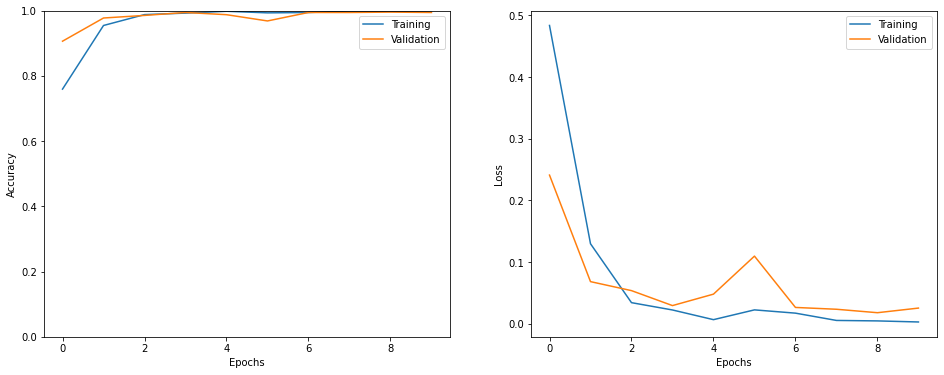

In [ ]:
show_history(history_ht)

### Utilizing a pre-trained model from TensorFlow Hub.

In [ ]:
import tensorflow_hub as hub

#We are testing two models from tensorflow hub
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = inception_v3
     

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

model_tf = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  feature_extractor_layer,
  tf.keras.layers.Dense(1,activation='sigmoid')
])

model_tf.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'])
     
history_tf= model_tf.fit(train_df,
          validation_data=val_df,
          epochs=15
          )      

Epoch 1/15
250/250 [==============================] - 35s 110ms/step - loss: 0.5121 - accuracy: 0.7465 - val_loss: 0.3920 - val_accuracy: 0.8397
Epoch 2/15
250/250 [==============================] - 23s 91ms/step - loss: 0.3659 - accuracy: 0.8454 - val_loss: 0.3280 - val_accuracy: 0.8747
Epoch 3/15
250/250 [==============================] - 23s 92ms/step - loss: 0.3042 - accuracy: 0.8838 - val_loss: 0.2985 - val_accuracy: 0.8860
Epoch 4/15
250/250 [==============================] - 24s 94ms/step - loss: 0.2693 - accuracy: 0.9001 - val_loss: 0.2546 - val_accuracy: 0.9165
Epoch 5/15
250/250 [==============================] - 23s 91ms/step - loss: 0.2410 - accuracy: 0.9178 - val_loss: 0.2405 - val_accuracy: 0.9176
Epoch 6/15
250/250 [==============================] - 23s 91ms/step - loss: 0.2211 - accuracy: 0.9263 - val_loss: 0.2171 - val_accuracy: 0.9379
Epoch 7/15
250/250 [==============================] - 23s 91ms/step - loss: 0.2045 - accuracy: 0.9323 - val_loss: 0.2076 - val_accuracy

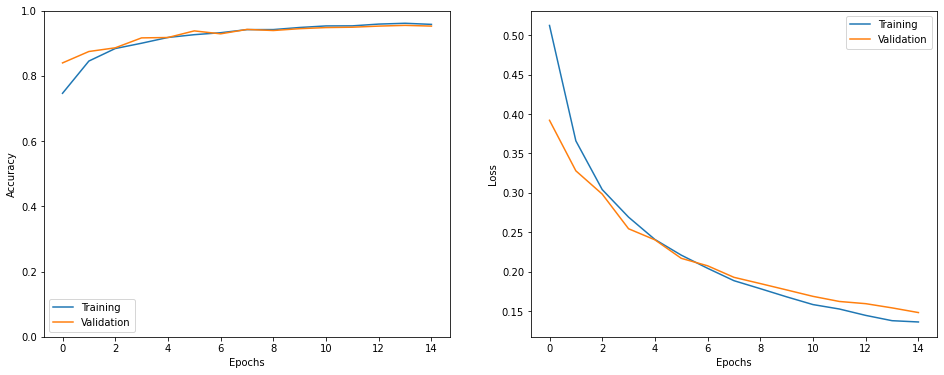

In [ ]:
show_history(history_tf)

## STEP (6/6)

To evaluate the performance of our models, let's use the test dataset for testing

In [ ]:
print("Simple CNN Model")

print( 'Model Accuracy:' +str(model.evaluate(test_df, verbose=0)[1]))
print( 'Model Loss:' +str(model.evaluate(test_df,verbose=0)[0]))

Simple CNN Model
Model Accuracy:0.6566666960716248
Model Loss:2.762312412261963


In [ ]:
print("Optimized CNN Model")

print( 'Model Accuracy:' +str(model_ht.evaluate(test_df, verbose=0)[1]))
print( 'Model Loss:' +str(model_ht.evaluate(test_df,verbose=0)[0]))

Optimized CNN Model
Model Accuracy:0.8333333134651184
Model Loss:1.0146564245224


In [ ]:
print("Pre-trained Model from tensorflow hub")

print( 'Model Accuracy:' +str(model_tf.evaluate(test_df, verbose=0)[1]))
print( 'Model Loss:' +str(model_tf.evaluate(test_df,verbose=0)[0]))

Pre-trained Model from tensorflow hub
Model Accuracy:0.7666666507720947
Model Loss:0.4961099326610565
